# | HW1 | Practice 4 Model(MobileNet V2 SSD) 개선

Practice 4 실습파일에 제공된 모델은 Detection layer 5개, 3가지 종류의 Aspect ratio를 가진 Anchor box로 구성된다.
Model의 Detection 성능을 향상시키기 위해 모델에 아래 다섯가지 사항을 반영하라.

**Due: 4/11, 11:59 PM**
        
**제출** : 다섯가지 사항을 반영한 결과를 **보고서**에 작성후 과제를 수행한 **Jupyter Notebook**과 함께 **"HW1_학번_이름.zip"** 형태로 제출하여라.
- **최종 제출물 형태 예시** : HW1_2024_12345_jiseojin.zip
    - **jupyter notebook**
        - 예시 : HW1_2024_12345_jiseojin.ipynb
        - output 지우지 않고 제출
    - **보고서(pdf)**
        - 예시 : HW1_2024_12345_jiseojin.pdf
        - 아래 내용을 포함 필수
            - 원본 실습 코드에서 어느 부분을 어떻게 수정하였는지에 대한 설명
            - 수정된 모델을 Training하고 최고 성능을(mAP)를 기록

### 1. Detection Layer 추가 (30%)
- Detection Layer 1개 추가
    - Layer width = 28인 Detection Layer를 3번째 Bottleneck Block 뒤에 추가하여라.

### 2. Aspect Ratio 추가 (30%)
Anchor box의 aspect ratio가 1, 2, 1/2만 사용되고 있다. SSD 논문에서 사용한 Aspect ratio들을 활용하기 위해 아래의 변화를 반영해 보자.
- Aspect ratio가 1인 detection layer에 대하여 현재 Layer의 s값과 다음 Layer의 s값을 곱한뒤 제곱근을 취한 값을 곱해주도록 변경하여라.
    - 힌트: aspect ratio 1인 박스는 2개다, SSDInputGenerator과 AnchorBox를 둘다 수정 해야한다
- 6개의 Detection layer가 있는 상태에서, (2,3,4)번째 Layer에 대하여만 aspect ratio=3, 1/3을 추가한다.  
- SSD 논문에서 해당 내용은 아래와 같다.
![SSD_AnchorBox_Explanation.PNG](attachment:SSD_AnchorBox_Explanation.PNG)

### 3. Loss 함수 변경 (20%)
현재 Localization loss는 L2 loss가 사용되고 있다. 이를 Smooth L1 Loss(Huber Loss)로 바꾸어 적용하여라.
- Smooth L1 Loss는 아래와 같다. (delta=1을 적용)
    ![Huber%20Loss.PNG](attachment:Huber%20Loss.PNG)
- Huber Loss는 직접 구현 하여라 (tf.keras.losses.Huber 와 같이 외부 라이브러리 사용시 0점)

### 4. Data Augmentation (10%)
- 이미지에 Random horizontal flip을 적용하여라.
- **중요** Canvas 전체를 flip하지 말고, CIFAR10 이미지를 flip한 후, canvas에 랜덤하게 배치한다.

### 5. mAP 성능 (10%)
- IoU=0.5:0.95기준 0.3 이상 달성하여라

## <과제 유의사항>
조교가 트레이닝을 수행해본 결과 트레이닝 중에 mAP의 등락이 있는 것이 발견되었다. Data의 특성에 의한 것으로 판단되니, 이러한 현상이 발견되더라도 당황하지 말고 트레이닝을 진행해도 된다.

In [ ]:
import os
import socket
import pickle
import time
import math
import numpy as np
import cv2
import struct
from tqdm import tqdm
from sys import getsizeof
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import model_selection

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Add, ReLU, Input, Dense, Dropout, Activation, Flatten \
    , Conv2D, MaxPooling2D, InputLayer, Reshape, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.python.keras import backend
from tensorflow.python.keras.utils import layer_utils
from tensorflow.keras.applications import imagenet_utils # Updated import statement


In [ ]:
IMG_SIZE = 224
n_classes = 10
pos_iou_threshold = 0.3
neg_iou_threshold = 0.3
score_threshold = 0.01
layer_width=[28,14,7,4,2,1]
num_boxes = [3,5,5,5,3,3]
aspect_ratio = []
s_max = 0.9
s_min = 0.5
batch_size = 16
log_dir = './'
model_name = 'mobilenetSSD'
model_csv_path  = os.path.join(log_dir, (model_name + '.csv'))

In [ ]:
#Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

train_size = x_train.shape[0]
test_size = x_test.shape[0]

In [ ]:
from utils import calc_iou, match_bipartite_greedy, match_multi, convert_coord

In [ ]:
data_augmentation= tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')
])

augmented_images = data_augmentation(x_train)

augmented_images_np = np.array(augmented_images)



In [ ]:
class SSDInputEncodingGenerator(keras.utils.Sequence):
    def __init__(self,
                 img_height,
                 img_width,
                 layer_width,
                 n_classes,
                 num_boxes,
                 s_max,
                 s_min,
                 aspect_ratio,
                 pos_iou_threshold,
                 neg_iou_threshold,
                background_id,
                 images,
                 labels,
                 data_size,
                batch_size=32):
        #Consider Background class
        self.img_height = img_height
        self.img_width = img_width
        self.n_class_withbg = n_classes + 1  #Add background class
        self.num_boxes = num_boxes  #List of number of boxes in each classifier layer
        self.s_max = s_max # Largest scale of default box
        self.s_min = s_min # Smallest scale of default box
        self.aspect_ratio = aspect_ratio # List of aspect ratios
        self.layer_width = layer_width
        self.pos_iou_threshold = pos_iou_threshold
        self.neg_iou_threshold = neg_iou_threshold
        self.background_id = background_id
        self.batch_size=batch_size
        self.images = images
        self.labels = labels
        self.shuffle = False
        self.data_size = data_size

        self.xmin_random = np.random.randint(self.img_height - 64, size=[self.data_size])
        self.ymin_random = np.random.randint(self.img_height - 64, size=[self.data_size])

        self.on_epoch_end()
        self.ar_list_component= self.update_aspect_ratios(self.num_boxes)

    def update_aspect_ratios(self,num_boxes):
        for num in self.num_boxes:
            if num == 3:
                self.aspect_ratio.append([1, 2, 1/2])
            elif num == 5:
                self.aspect_ratio.append([1, 2, 1/2, 3, 1/3])
        ar_list_component=self.aspect_ratio
        return ar_list_component



    def convert_image(self, image, label, indexes):
        """
        Convert classification data to object detection data
        Randomly locate image in the middle of black canvas
        Input
            x: Image, shape: (batch_size, image size, image size, #channels)
            y: label, shape: (batch_size, )
        output
            out_x: Image located in the random location of black canvas, shape: (batch_size, canvas size, canvas size, 3)
            out_y: label and location of corners(xmin,ymin,xmax,ymax), shape: (batch_size, #objects per image, 1+4) #Objects per image = 1

        """
        orig_image_size = 64
        channels = image.shape[-1]

        #prepare black canvas
        canvas = np.zeros((self.batch_size, self.img_height, self.img_width, channels), np.int64)
        out_y = np.zeros((self.batch_size, 1, 5))

        xmin = self.xmin_random[indexes]
        ymin = self.ymin_random[indexes]
        xmax = xmin + orig_image_size
        ymax = ymin + orig_image_size


        resized = np.zeros((orig_image_size, orig_image_size, 3))
        for i in range(batch_size):
            resized = cv2.resize(image[i], dsize=(orig_image_size, orig_image_size))
            canvas[i, xmin[i]:xmax[i], ymin[i]:ymax[i], :] = resized

        out_y[:, 0,0] = label[:,0]
        out_y[:, 0, -4:] = np.column_stack([xmin, ymin, xmax, ymax])

        return canvas, out_y

    def __getitem__(self, index):
        '''
        Generate one batch of data
        '''
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        '''
        Updates indexes after each epoch
        '''
        self.indexes = np.arange(self.data_size)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.images.shape[0] / self.batch_size))

    def __data_generation(self, indexes):
        """
        Input: ground truth label,shape: (batch_size, #object per image, 1 + 4)
        Output: y_encoded, shape: (batch_size, sum of grid size of all classifier * num_boxes, n_class_withbg + 4 + 4)
        1. Create y_encoded template: (B, num_boxes, class + 4 + 4) 4 for gt coordinates and 4 for anchor boxes
        2. For each ground truth, calculate iou of gt and anchor boxes
        3. Find the highest matching anchor box per each gt and fill in y_encoded template
        4. Multi object matching
        5. Apply negative iou threshold
        6. Transform into Delta format
        """

        images, gt_label = self.convert_image(self.images[indexes], self.labels[indexes], indexes)

        # Make class vector to one hot format
        class_vector = np.eye(self.n_class_withbg)

        #layer_width=[14,7,4,2,1]
        for iw in range(len(layer_width)):
            # s_max = 0.9  s_min = 0.5
            s = s_min + (s_max - s_min) / (len(layer_width) - 1) * (len(layer_width) - iw - 1)
            l = layer_width[iw]
            num_box = self.num_boxes[iw]       # num_boxes = [3,3,3,3,3]
            box_tensor = np.zeros((l * l * num_box, 4))
            ar_list= self.ar_list_component[iw]

            for i in range(l):
                for j in range(l):

                        for box_idx in range(num_box):
                            box_tensor[(i * l + j) * num_box + box_idx, 0] = (0.5 + i) / l
                            box_tensor[(i * l + j) * num_box + box_idx, 1] = (0.5 + j) / l

                            # Aspect ratio calculation
                            ar = ar_list[box_idx]
                            if ar == 1:
                                if iw < len(layer_width) - 1:
                                    s_next = s_min + (s_max - s_min) / (len(layer_width) - 1) * (len(layer_width) - iw - 2)
                                    adjusted_s = math.sqrt(s * s_next)
                                else:
                                    adjusted_s = s
                                box_tensor[(i * l + j) * num_box + box_idx, 2] = adjusted_s / l
                                box_tensor[(i * l + j) * num_box + box_idx, 3] = adjusted_s / l
                            else:
                                box_tensor[(i * l + j) * num_box + box_idx, 2] = s * math.sqrt(ar) / l
                                box_tensor[(i * l + j) * num_box + box_idx, 3] = s / math.sqrt(ar) / l


            ### 실습 끝

            box_tensor = convert_coord(box_tensor, type='centroid2corner')

            if iw == 0:
                boxes_tensor = box_tensor
            else:
                boxes_tensor = np.concatenate((boxes_tensor, box_tensor), axis = 0)

            class_tensor = np.zeros((l * l * num_box , self.n_class_withbg))

            if iw == 0:
                classes_tensor = class_tensor
            else:
                classes_tensor = np.concatenate((classes_tensor, class_tensor), axis = 0)

        box_class_tensor= np.concatenate((classes_tensor, boxes_tensor, boxes_tensor), axis = 1)
        y_encoded = np.tile(box_class_tensor, (self.batch_size, 1, 1))

        y_encoded[:, :, self.background_id] = 1 # All boxes are background boxes by default.


        #Ground truth matching
        for i in range(self.batch_size):
            gt_one_label = gt_label[i]
            m = gt_one_label.shape[0]
            if gt_one_label.shape[0] == 0: continue # If there is no object, skip

            #Normalize ground truth
            gt_one_label[:,[-4,-2]] /= self.img_width
            gt_one_label[:,[-3,-1]] /= self.img_height

            #FInd the iou of ground truth and all anchor boxes
            similarities = calc_iou(gt_one_label[:,-4:], y_encoded[i, :, -4:])

            #Find the highest matching anchor box per each ground truth boxes
            matches = match_bipartite_greedy(similarities)

            #Convert ground truth class label to one hot encoding
            gt_class = np.array(gt_one_label[:,0] + 1, np.int64)

            #Fill in y_encoded
            y_encoded[i, matches, :self.n_class_withbg] = class_vector[gt_class]
            y_encoded[i, matches, -8:-4] = gt_one_label[:,1:]

            #Set the matched anchor boxes to 0 to indicate they are matched before multi object matching
            similarities[:,matches] = 0


            #Multi object matching
            #Similar process to bipartite matching
            matches_anchor, matches_gt = match_multi(similarities, threshold=self.pos_iou_threshold)

            if len(matches_gt) > 0:

                y_encoded[i, matches_anchor, :self.n_class_withbg] = class_vector[gt_class[matches_gt]]
                y_encoded[i, matches_anchor, -8:-4] = gt_one_label[matches_gt,1:]

                #Set the matched anchor boxes to 0 to indicate they are matched before applying negative iou threshold
                similarities[:,matches_anchor] = 0

            #All background boxes whose iou are greater than neg_iou_threshold
            # are set to neutral(neither background nor class)
            max_bg_similarities = np.amax(similarities, axis = 0)
            neutral_boxes = np.nonzero(max_bg_similarities >= self.neg_iou_threshold)[0]
            y_encoded[i, neutral_boxes, self.background_id] = 0

        #Convert coordinate from corner 2 centroid
        y_encoded[:,:,:-4] = convert_coord(y_encoded[:,:,:-4], type='corner2centroid')
        #print(y_encoded[0,0])
        y_encoded = convert_coord(y_encoded, type='corner2centroid')
        #print(y_encoded[0,0])

        y_encoded[:,:,[-8, -7]] -= y_encoded[:,:,[-4, -3]] # (cx(gt) - cx(d_box)) # (cy(gt) - cy(d_box))
        y_encoded[:,:,[-8, -7]] /= y_encoded[:,:,[-2, -1]] # (cx(gt) - cx(d_box)) / w(d_box) # (cy(gt) - cy(d_box)) / h(d_box)
        y_encoded[:,:,[-6, -5]] = np.log(y_encoded[:,:,[-6, -5]] / y_encoded[:,:,[-2, -1]]) #log(w(gt) / w(d_box)) #log(h(gt) / h(d_box))

        return images, y_encoded

In [ ]:
ssd_input_gen = SSDInputEncodingGenerator(IMG_SIZE,
                 IMG_SIZE,
                 layer_width=layer_width,
                 n_classes=n_classes,
                 num_boxes=num_boxes,
                 s_max=s_max,
                 s_min=s_min,
                 aspect_ratio=aspect_ratio,
                 pos_iou_threshold=pos_iou_threshold,
                 neg_iou_threshold=neg_iou_threshold,
                 background_id=0,
                 images=augmented_images_np,
                 labels=y_train,
                data_size=train_size,
                batch_size=batch_size)

In [ ]:
import matplotlib.patches as patches

def show(image, label, img_width, img_height):

    fig,ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(image)
    gt_boxes = np.argwhere(label[:,0]==0)

    for match in gt_boxes:
        anchor_box = label[match[0],-4:]
        gt_box = label[match[0],-8:-4]
        xmin = anchor_box[0] - anchor_box[2]/2
        ymin = anchor_box[1] - anchor_box[3]/2
        w = anchor_box[2]
        h = anchor_box[3]

        w_gt = math.exp(gt_box[2]) * anchor_box[2] * img_width
        h_gt = math.exp(gt_box[3]) * anchor_box[3] * img_width
        cx_gt = (gt_box[0] * anchor_box[2] + anchor_box[0]) * img_width
        cy_gt = (gt_box[1] * anchor_box[3] + anchor_box[1]) * img_width
        xmin_gt = (cx_gt - w_gt/2)
        ymin_gt = (cy_gt - h_gt/2)

        rect = patches.Rectangle((ymin_gt,xmin_gt),h_gt,w_gt,linewidth=1,edgecolor='g',facecolor='none')
        ax.text(ymin_gt+1, xmin_gt+5, 'Ground truth box', color='g')
        ax.add_patch(rect)

        xmin *= img_width
        ymin *= img_height
        w *= img_width
        h *= img_height

        rect = patches.Rectangle((ymin,xmin),h,w,linewidth=1,edgecolor='b',facecolor='none')
        ax.text(ymin+1, xmin+5, 'Matched anchor box: {}'.format(match[0]), color='b')
        ax.add_patch(rect)
    plt.show()


In [ ]:
!pip uninstall numpy

!pip install numpy==1.23.5



Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 13.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; pyth

In [ ]:
!pip install numpy==1.23.5


In [ ]:
image, label = next(iter(ssd_input_gen))

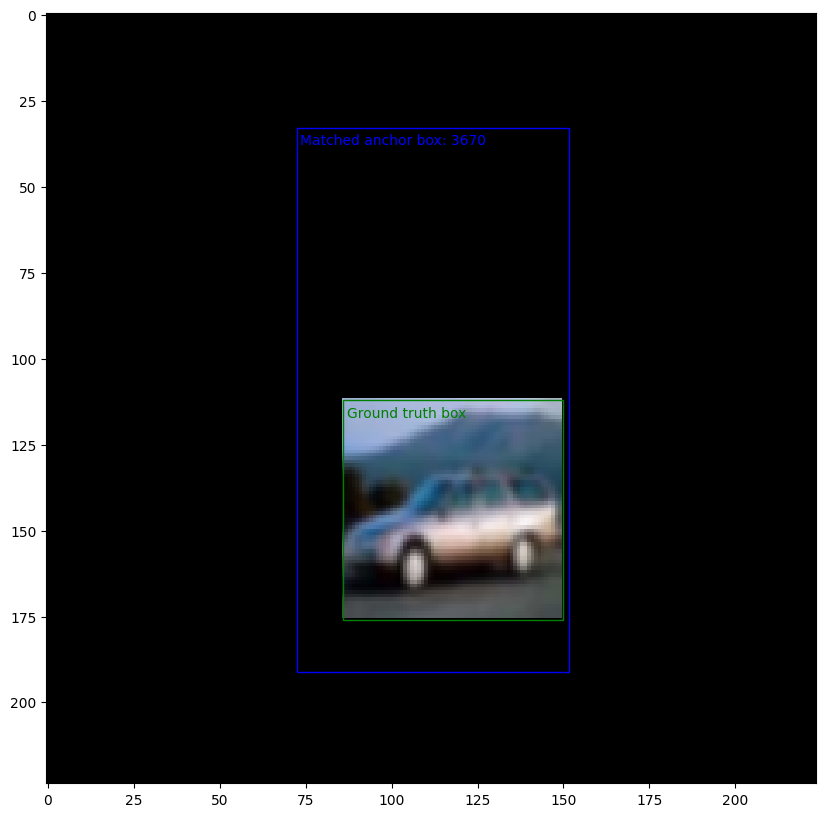

In [ ]:
show(image[4], label[4], IMG_SIZE, IMG_SIZE)

In [ ]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor) # 더 가까운 divisor의 배수로 올림 4,5,6,7,8,9,10,11 -> 8, 12~19 -> 16 ...
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [ ]:
def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    #Get the channel axis and the input channel size
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
    in_channels = backend.int_shape(inputs)[channel_axis]

    pointwise_conv_filters = int(alpha * filters)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8) # Make sure the output filter size is the multiple of 8

    #Set the prefix
    prefix = 'block_{}_'.format(block_id)

    x = inputs

    #Expansion block
    if block_id: # No expansion for block 0
        x = layers.Conv2D(filters = expansion * in_channels, kernel_size = 1, strides = 1, padding='same',
                          use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                          name=prefix + 'expand')(x)
        x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001,
                                      name=prefix + 'expand_BN')(x)
        x = layers.ReLU(6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'


    #Depthwise convolution
    #if stride == 2:
        #Adjust zero paddings for strides, when input hieght and width are odd add (1,1,1,1) padding / when even, add (0,1,0,1)
        #x = layers.ZeroPadding2D(padding=correct_pad(x, 3),
        #                         name=prefix + 'pad')(x)

    x = layers.DepthwiseConv2D(kernel_size = 3, strides = stride,
                               #padding='same' if stride == 1 else 'valid',
                               padding='same',
                               use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                               name=prefix + 'depthwise')(x)
    x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001,
                                 name=prefix + 'depthwise_BN')(x)
    x = layers.ReLU(6, name=prefix + 'relu')(x)

    #Pointwise convolution(Bottleneck)
    x = layers.Conv2D(filters = pointwise_filters, kernel_size = 1, strides = 1, padding='same',
                      use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                      name=prefix + 'project')(x)
    x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001,
                                 name=prefix + 'project_BN')(x)

    #Inverted residual only when valid(Input size = output_size)
    if in_channels == pointwise_filters and stride == 1:
        return layers.add([inputs, x])
    return x

In [ ]:
from tensorflow.keras.layers import Layer, InputSpec

class AnchorBoxes(Layer):
    def __init__(self, layer_width, n_class_withbg, num_boxes,
                 s_max, s_min, aspect_ratio, index, **kwargs):
        self.layer_width = layer_width
        self.n_class_withbg = n_class_withbg
        self.num_boxes = num_boxes
        self.s_max = s_max
        self.s_min = s_min
        self.aspect_ratio = aspect_ratio
        self.index = index
        super(AnchorBoxes, self).__init__(**kwargs)

        self.ar_list_component= self.update_aspect_ratios(self.num_boxes)

    def update_aspect_ratios(self,num_boxes):
        for num in self.num_boxes:
            if num == 3:
                self.aspect_ratio.append([1, 2, 1/2])
            elif num == 5:
                self.aspect_ratio.append([1, 2, 1/2, 3, 1/3])
        ar_list_component=self.aspect_ratio
        return ar_list_component


    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(AnchorBoxes, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        if K.image_dim_ordering() == 'tf':
            batch_size, feature_map_height, feature_map_width, feature_map_channels = input_shape

        return (batch_size, feature_map_height*feature_map_width*self.n_boxes, 4)

    def get_config(self):
        config = {
            'layer_width': list(self.layer_width),
            'n_class_withbg': self.n_class_withbg,
            'num_boxes': self.num_boxes,
            's_max': self.s_max,
            's_min': self.s_min,
            'aspect_ratio': list(self.aspect_ratio)
        }
        base_config = super(AnchorBoxes, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):
        s = self.s_min + (self.s_max - self.s_min) / (len(self.layer_width) - 1) * (len(self.layer_width) - self.index - 1)
        l = self.layer_width[self.index]
        num_box = self.num_boxes[self.index]
        box_tensor = np.zeros((l * l * num_box, 4))

        ar_list= self.ar_list_component[self.index]

        for i in range(l):
            for j in range(l):
                for box_idx in range(num_box):
                              box_tensor[(i * l + j) * num_box + box_idx, 0] = (0.5 + i) / l
                              box_tensor[(i * l + j) * num_box + box_idx, 1] = (0.5 + j) / l

                              # Aspect ratio calculation
                              ar = ar_list[box_idx]
                              if ar == 1:
                                  # Initialize iw as the index of the current layer
                                  iw = self.index
                                  if iw < len(self.layer_width) - 1: # Use self.layer_width
                                      s_next = self.s_min + (self.s_max - self.s_min) / (len(self.layer_width) - 1) * (len(self.layer_width) - iw - 2)
                                      adjusted_s = math.sqrt(s * s_next)
                                  else:
                                      adjusted_s = s
                                  box_tensor[(i * l + j) * num_box + box_idx, 2] = adjusted_s / l
                                  box_tensor[(i * l + j) * num_box + box_idx, 3] = adjusted_s / l
                              else:
                                  box_tensor[(i * l + j) * num_box + box_idx, 2] = s * math.sqrt(ar) / l
                                  box_tensor[(i * l + j) * num_box + box_idx, 3] = s / math.sqrt(ar) / l

        box_tensor = np.expand_dims(box_tensor, axis = 0)
        return tf.tile(tf.constant(box_tensor, dtype=tf.float32), (tf.shape(x)[0],1,1))

In [ ]:
def MobileNetV2SSD(input_shape,
                n_classes,
                layer_width,
                num_boxes,
                alpha=1.0):

    n_class_withbg = n_classes + 1 # Add background class

    inputs = layers.Input(shape=input_shape)

    first_block_filters = _make_divisible(32 * alpha, 8)
    # first conv layer: 224x224x3 -> 112x112x32
    x = layers.Conv2D(first_block_filters, kernel_size=3, strides=(2, 2), padding='same',  use_bias=False,
                      bias_initializer='zeros',  kernel_regularizer=regularizers.l2(0.00004),
                      name='Conv1')(inputs)

    x = layers.BatchNormalization(
      axis=-1, epsilon=1e-3, momentum=0.999, name='bn_Conv1')(x)

    x = layers.ReLU(6., name='Conv1_relu')(x)


    # inverted residual blocks
    # 1st bottleneck block: 112x112x32 -> 112x112x16
    x = _inverted_res_block(
      x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)

    # 2nd bottleneck block: 112x112x16 -> 56x56x24
    x = _inverted_res_block(
      x, filters=24, alpha=alpha, stride=2, expansion=6, block_id=1)
    x = _inverted_res_block(
      x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2)

    # 3rd bottleneck block: 56x56x24 -> 28x28x32
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4)
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5)

    classifier_1_conf = layers.Conv2D(num_boxes[0] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_1_conf')(x)
    classifier_1_loc = layers.Conv2D(num_boxes[0] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_1_loc')(x)

    # 4th bottleneck block: 28x28x32 -> 14x14x64
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=6)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=7)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=8)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=9)

    classifier_2_conf = layers.Conv2D(num_boxes[1] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_2_conf')(x)
    classifier_2_loc = layers.Conv2D(num_boxes[1] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_2_loc')(x)


    x = layers.Conv2D(256, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) #7x7

    classifier_3_conf = layers.Conv2D(num_boxes[2] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_3_conf')(x)
    classifier_3_loc = layers.Conv2D(num_boxes[2] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_3_loc')(x)

    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 4x4

    classifier_4_conf = layers.Conv2D(num_boxes[3] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_4_conf')(x)
    classifier_4_loc = layers.Conv2D(num_boxes[3] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_4_loc')(x)

    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 2x2

    classifier_5_conf = layers.Conv2D(num_boxes[4] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_5_conf')(x)
    classifier_5_loc = layers.Conv2D(num_boxes[4] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_5_loc')(x)

    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 1x1

    classifier_6_conf = layers.Conv2D(num_boxes[5] * n_class_withbg, kernel_size = 3, padding='same', use_bias=False, name='classifier_6_conf')(x)
    classifier_6_loc = layers.Conv2D(num_boxes[5] * 4, kernel_size = 3, padding='same', use_bias=False, name='classifier_6_loc')(x)


    ### 아래 실습하면서 완성
    #Classification tensors
    classifier_1_conf = layers.Reshape((layer_width[0] * layer_width[0] * num_boxes[0], n_class_withbg))(classifier_1_conf)
    classifier_2_conf = layers.Reshape((layer_width[1] * layer_width[1] * num_boxes[1], n_class_withbg))(classifier_2_conf)
    classifier_3_conf = layers.Reshape((layer_width[2]*layer_width[2]*num_boxes[2], n_class_withbg))(classifier_3_conf)
    classifier_4_conf = layers.Reshape((layer_width[3]*layer_width[3]*num_boxes[3], n_class_withbg))(classifier_4_conf)
    classifier_5_conf = layers.Reshape((layer_width[4]*layer_width[4]*num_boxes[4], n_class_withbg))(classifier_5_conf)
    classifier_6_conf = layers.Reshape((layer_width[5]*layer_width[5]*num_boxes[5], n_class_withbg))(classifier_6_conf)
    conf_layers = layers.concatenate([classifier_1_conf, classifier_2_conf, classifier_3_conf, classifier_4_conf, classifier_5_conf,classifier_6_conf], axis = 1)


    #Apply softmax
    conf_layers_softmax = layers.Activation('softmax')(conf_layers)

    #Localization tensors
    classifier_1_loc = layers.Reshape((layer_width[0] * layer_width[0] * num_boxes[0], 4))(classifier_1_loc)
    classifier_2_loc = layers.Reshape((layer_width[1] * layer_width[1] * num_boxes[1], 4))(classifier_2_loc)
    classifier_3_loc = layers.Reshape((layer_width[2]*layer_width[2]*num_boxes[2], 4))(classifier_3_loc)
    classifier_4_loc = layers.Reshape((layer_width[3]*layer_width[3]*num_boxes[3], 4))(classifier_4_loc)
    classifier_5_loc = layers.Reshape((layer_width[4]*layer_width[4]*num_boxes[4], 4))(classifier_5_loc)
    classifier_6_loc = layers.Reshape((layer_width[5]*layer_width[5]*num_boxes[5], 4))(classifier_6_loc)

    loc_layers = layers.concatenate([classifier_1_loc, classifier_2_loc, classifier_3_loc, classifier_4_loc, classifier_5_loc,classifier_6_loc], axis = 1)

    #Default anchor box tensors, They are constant and NOT trained !!
    #def __init__(self, layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index, **kwargs):
    dbox_1 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 0)(classifier_1_loc)
    dbox_2 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 1)(classifier_2_loc)
    dbox_3 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 2)(classifier_3_loc)
    dbox_4 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 3)(classifier_4_loc)
    dbox_5 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 4)(classifier_5_loc)
    dbox_6 = AnchorBoxes(layer_width, n_class_withbg, num_boxes, s_max, s_min, aspect_ratio, index = 5)(classifier_6_loc)

    dbox_layers = layers.concatenate([dbox_1, dbox_2, dbox_3, dbox_4, dbox_5, dbox_6], axis = 1)

    ### 실습 끝


    #Concatenate Classification tensor, Localization tensor and Default anchor box tensor.
    detections = layers.concatenate([conf_layers_softmax, loc_layers, dbox_layers], axis=-1)

    outputs = detections

    return Model(inputs=inputs, outputs=outputs)


In [ ]:
model = MobileNetV2SSD((IMG_SIZE, IMG_SIZE, 3), n_classes, layer_width, num_boxes, alpha=1.0)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_7[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
class SSDLoss():
    def __init__(self, n_classes, background_id, neg_pos_ratio=3, n_neg_min=0, alpha=1.0, beta=1.0):
        self.neg_pos_ratio = neg_pos_ratio
        self.n_neg_min = 0
        self.alpha = alpha
        self.beta = beta
        self.background_id = background_id
        self.n_class_withbg = n_classes + 1


    def smoothL1Loss(self, loc_true, loc_pred):
        """
        y_true: ground truth localization tensor, shape: (batch_size, num_boxes, 4)
        y_pred: predicted localization tensor, shape: (batch_size, num_boxes, 4)
        """
        diff = tf.abs(loc_pred - loc_true)
        less_than_one = tf.cast(tf.less(diff, 1.0), tf.float32)
        smooth_l1_loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
        return tf.reduce_sum(smooth_l1_loss, axis=-1)


    def log_loss(self, class_true, class_pred):
        #classification loss
        class_pred = tf.maximum(class_pred, 1e-15)
        log_loss = -tf.reduce_sum(class_true * tf.math.log(class_pred), axis=-1)  # (batch_size, n_boxes)
        return log_loss

    def compute_loss(self, y_true, y_pred):
        """
        y_true: (batch_size, # boxes, n_class_withbg + 4)
        y_pred: (batch_size, # boxes, n_class_withbg + 4)
        """

        #Get the size of tensor
        batch_size = tf.shape(y_true)[0]
        n_boxes = tf.shape(y_pred)[1]

        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)

        classification_loss = self.log_loss(y_true[:, :, :self.n_class_withbg], y_pred[:, :, :self.n_class_withbg])
        positives = tf.reduce_max(y_true[:, :, 1:(self.n_class_withbg)], axis=-1) # Class is NOT background, (batch_size, n_boxes)

        # Classification loss for positive boxes
        pos_class_loss = tf.reduce_sum(self.log_loss(y_true[:, :, 1:self.n_class_withbg], y_pred[:, :, 1:self.n_class_withbg]), axis=-1)

        negatives = y_true[:,:, self.background_id] # Class is background, (batch_size, n_boxes)
        n_positives = tf.reduce_sum(positives) # number of positive boxes, single number

        # Classification loss for negative boxes
        neg_class_loss_all = classification_loss * negatives #(batch_size, n_boxes)
        n_neg_losses = tf.math.count_nonzero(neg_class_loss_all, dtype=tf.int32) # The number of nonzero entries in neg_class_loss_all

        # Keep the number of negative boxes between n_neg_min and neg_pos_ratio * positive_boxes
        n_negative_keep = tf.minimum(tf.maximum(self.neg_pos_ratio * tf.cast(n_positives, dtype=tf.int32), self.n_neg_min), n_neg_losses)

        def f1():
            return tf.zeros([batch_size])

        # Get the "n_negative_keep" largest confidence negative boxes.
        def f2():
            #Resahpe neg_class_loss_all to 1d array
            neg_class_loss_all_1D = tf.reshape(neg_class_loss_all, [-1])

            # Find top 'n_negative_keep' boxes from neg_class_loss_all_1D
            values, indices = tf.nn.top_k(neg_class_loss_all_1D, k=n_negative_keep, sorted=False)

            #Then create a mask for negative boxes: For selected box above, set them as 1
            negatives_keep = tf.scatter_nd(indices=tf.expand_dims(indices, axis=1),
                                           updates=tf.ones_like(indices, dtype=tf.int32),
                                           shape=tf.shape(neg_class_loss_all_1D))
            negatives_keep = tf.cast(tf.reshape(negatives_keep, [batch_size, n_boxes]), dtype=tf.float32)

            #Finally compute negative loss
            neg_class_loss = tf.reduce_sum(classification_loss * negatives_keep, axis=-1) #(batch_size)

            return neg_class_loss

        neg_class_loss = tf.cond(tf.equal(n_neg_losses, tf.constant(0)), f1, f2)

        #Final classification loss: Sum of positive and negative loss
        class_loss = self.beta * pos_class_loss + neg_class_loss

        #localization loss
        loc_pred = y_pred[:,:,self.n_class_withbg:-4]
        loc_true = y_true[:,:,self.n_class_withbg:-4]
        loc_loss = self.smoothL1Loss(loc_true, loc_pred) # (batch_size, n_boxes)

        # Include only positive boxes in calculating localization loss
        loc_loss = tf.reduce_sum(positives * loc_loss, axis=-1) #(batch_size)

        #Combine localization and classification loss, divide by matched default box(n_positives)
        total_loss = (class_loss + loc_loss * self.alpha) / tf.maximum(1.0, n_positives)

        # We divided by n_positives - # of all matched default boxes of "a batch"
        # Since keras divides by the size of batch, it is double division
        # To adjust this, we multiply by batch_size
        total_loss = total_loss * tf.cast(batch_size, dtype=tf.float32)

        return total_loss

In [ ]:
ssd_loss = SSDLoss(n_classes = n_classes, background_id=0, neg_pos_ratio=1, alpha=10, beta=3)
model.compile(loss=ssd_loss.compute_loss,
              optimizer=tf.keras.optimizers.Adam())
              #optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0))

In [ ]:
#decay could be applied using Learning rate scheduler
def decay(epoch):
    return 0.001 * (0.98 **(epoch - 1))

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
callbacks = []
"""
#TensorBoard로 훈련 성과를 보고 싶은 경우
callbacks.append(TensorBoard(log_dir=log_dir, histogram_freq=1))
"""

checkpoint_path = "/content/drive/MyDrive/training_checkpoints_SSD/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    print(f"Checkpoint directory {checkpoint_dir} created.")
else:
    print(f"Checkpoint directory {checkpoint_dir} already exists.")

# Checkpoint 콜백 설정
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_freq='epoch')


#Learning rate 스케쥴 설정
callbacks.append(LearningRateScheduler(decay))

#General logs on csv
callbacks.append(CSVLogger(model_csv_path))

Checkpoint directory /content/drive/MyDrive/training_checkpoints_SSD already exists.


In [ ]:
history = model.fit(ssd_input_gen,
              epochs=50,
              verbose=1,
              callbacks=callbacks)

Epoch 1/50
3125/3125 [==============================] - 7130s 2s/step - loss: 7.5256 - lr: 0.0010
Epoch 2/50
3125/3125 [==============================] - 7156s 2s/step - loss: 5.9698 - lr: 0.0010
Epoch 3/50
3125/3125 [==============================] - 7132s 2s/step - loss: 5.4092 - lr: 9.8000e-04
Epoch 4/50
3125/3125 [==============================] - 7160s 2s/step - loss: 4.9450 - lr: 9.6040e-04
Epoch 5/50
3125/3125 [==============================] - 7225s 2s/step - loss: 4.5068 - lr: 9.4119e-04
Epoch 6/50
 815/3125 [======>.......................] - ETA: 1:29:30 - loss: 4.1493

In [ ]:
y_pred = model.predict(image)

In [ ]:
from utils import decode_detections

In [ ]:
# Decode the prediction for one image in the image batch
image_no = 0
y_decoded = decode_detections(np.expand_dims(y_pred[image_no], axis=0),
                            n_classes=10,
                              confidence_thresh=0.01,
                              iou_threshold=0.45,
                              top_k=10,
                              img_height=IMG_SIZE,
                              img_width=IMG_SIZE,
                              background_id=0)

In [ ]:
y_pred[image_no,:,0]

In [ ]:
# Visualize the bounding box on the original image
import matplotlib.patches as patches

def show_prediction(image, label, prediction):

    fig,ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(image)
    gt_boxes = np.argwhere(label[:,0]==0)
    for match in gt_boxes:
        anchor_box = label[match[0],-4:]
        gt_box = label[match[0], -8:-4]
        class_id = np.argwhere(label[match[0],:10]==1)

        w = math.exp(gt_box[2]) * anchor_box[2]
        h = math.exp(gt_box[3]) * anchor_box[3]
        cx = gt_box[0] * anchor_box[2] + anchor_box[0]
        cy = gt_box[1] * anchor_box[3] + anchor_box[1]

        xmin = (cx - w/2) * IMG_SIZE
        ymin = (cy - h/2) * IMG_SIZE
        w = w * IMG_SIZE
        h = h * IMG_SIZE

        rect = patches.Rectangle((ymin,xmin),h, w,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect)
        ax.text(ymin+1, xmin+w-5, 'ground truth: ' + str(class_id[0,0]), color='g')

    pred_boxes= np.argwhere(prediction[:,1] > 0)

    for pred in pred_boxes:
        box = prediction[pred[0],2:6]
        class_id = int(prediction[pred[0],0])
        prob = prediction[pred[0],1]
        xmin = min(max(box[0],0),224)
        ymin = min(max(box[1],0),224)
        w = min(max(box[2],0),224) - xmin
        h = min(max(box[3],0),224) - ymin
        rect = patches.Rectangle((ymin,xmin),h, w,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ax.text(ymin+1, xmin+5, 'class: {}, prob: {:.2f}'.format(class_id, prob), color='r')

    plt.show()

In [ ]:
show_prediction(image[image_no],label[image_no],y_decoded[0])

In [ ]:
ssd_test_gen = SSDInputEncodingGenerator(IMG_SIZE,
                 IMG_SIZE,
                 layer_width=layer_width,
                 n_classes=n_classes,
                 num_boxes=num_boxes,
                 s_max=s_max,
                 s_min=s_min,
                 aspect_ratio=aspect_ratio,
                 pos_iou_threshold=pos_iou_threshold,
                 neg_iou_threshold=neg_iou_threshold,
                 background_id=0,
                 images=x_test,
                 labels=y_test,
                data_size=test_size,
                batch_size=batch_size)

In [ ]:
test_image, test_label = next(iter(ssd_test_gen))

In [ ]:
test_pred = model.predict(test_image)

In [ ]:
image_no = 0
test_decoded = decode_detections(np.expand_dims(test_pred[image_no], axis=0),
                            n_classes=10,
                              confidence_thresh=0.01,
                              iou_threshold=0.45,
                              top_k=100,
                              img_height=IMG_SIZE,
                              img_width=IMG_SIZE,
                              background_id=0)

In [ ]:
show_prediction(test_image[image_no],test_label[image_no],test_decoded[0])

In [ ]:
# Function to dump prediction result in JSON format
import json

def dump_coco_json(dataset_size, batch_size, generator, model, out_file):

    # Put the results in this list.
    results = []
    id_cnt = 0

    for batch_X, batch_label in generator:
        # Generate batch.
        #batch_X, batch_label = next(generator)
        # Predict.
        y_pred = model.predict(batch_X)

        # Decode.
        y_pred = decode_detections(y_pred,
                                   n_classes=10,
                                   confidence_thresh=0.01,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   img_height=IMG_SIZE,
                                  img_width=IMG_SIZE,
                                  background_id=0)

        # Convert each predicted box into the results format.
        for k, batch_item in enumerate(y_pred):
            for box in batch_item:
                cat_id = box[0]
                # Round the box coordinates to reduce the JSON file size.
                xmin = float(round(box[2], 1))
                ymin = float(round(box[3], 1))
                xmax = float(round(box[4], 1))
                ymax = float(round(box[5], 1))
                width = xmax - xmin
                height = ymax - ymin
                bbox = [xmin, ymin, width, height]
                result = {}
                result['image_id'] = id_cnt
                result['category_id'] = cat_id
                result['score'] = float(round(box[1], 3))
                result['bbox'] = bbox
                results.append(result)
            id_cnt += 1
            if id_cnt == dataset_size:
                break


    with open(out_file, 'w') as f:
        json.dump(results, f)

    print("Prediction results saved in '{}'".format(out_file))
    return